---
title: Exploratory Data Analysis
---

In [13]:
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [14]:
sns.set_theme(context="paper", style="ticks", palette="deep", color_codes=True)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300

### EDA of match_results 

In [15]:
match_results = pd.read_csv(
    "data/match_results.csv", parse_dates=["Date"], dtype={"HeadCoach": "str"}
)
match_results.head()

,League,Country,Date,Team,Goals,Result,isHome,HeadCoach,DaysInPost
0,Premier League,England,2014-08-16,Manchester Utd,1.0,loss,True,Louis van Gaal,33.0
1,Premier League,England,2014-08-16,Arsenal,2.0,win,True,Arsène Wenger,6528.0
2,Premier League,England,2014-08-17,Liverpool,2.0,win,True,Brendan Rodgers,777.0
3,Premier League,England,2014-08-17,Newcastle Utd,0.0,loss,True,Alan Pardew,1347.0
4,Premier League,England,2014-11-01,Newcastle Utd,1.0,win,True,Alan Pardew,1423.0


In [16]:
head_coach = pd.read_csv(
    "data/head_coach.csv",
    dtype={"HeadCoach": "str"},
    parse_dates=["Appointed", "EndDate"],
)

In [17]:
min_season = match_results["Date"].dt.year.min() + 1
max_season = match_results["Date"].dt.year.max()
leagues = ", ".join(match_results["League"].unique())
n_match = floor(len(match_results) / 2)
n_team = match_results["Team"].nunique()
n_team_no_coach = (
    match_results.groupby(["Team"])["HeadCoach"].apply(lambda x: x.isnull().all()).sum()
)
perc_match_no_coach = (
    match_results["HeadCoach"].isnull().sum() / len(match_results)
) * 100
n_coach = head_coach["HeadCoach"].nunique()
n_appointments = len(head_coach)

Nous avons collecté les résultats des matchs et les mandats des entraîneurs sportif chef de la première division masculine de football pour les saisons {eval}`min_season` - {eval}`max_season` et pour les ligues suivantes : {eval}`leagues`.

Cela correspond à un total de {eval}`n_match` matchs joués par {eval}`n_team` équipes.
Parmi ces {eval}`n_team` équipes, {eval}`n_team_no_coach` équipes n'ont pas d'information sur les mandats des entraîneurs chefs pour tout ou partie des saisons 2015 à 2023. En proportion de match c'est {eval}`f'{perc_match_no_coach:.0f}'` % des matchs qui ne comportent pas d'information sur l'entraîneur chef.

Les données des mandats des entraîneurs sportifs contiennent {eval}`n_appointments` mandat d'entraîneurs chefs parmi {eval}`n_coach` entraîneurs uniques.

In [18]:
# | label: data_summary

match_summary = match_results.groupby(["League", "Country"]).agg(
    {
        "Team": "nunique",
        "Date": "size",
        "HeadCoach": lambda x: str(round((x.isnull().sum() / len(x)) * 100, 2)) + "%",
    }
)

match_summary.columns = [
    "Number of Teams",
    "Number of Matches",
    "Percentage of Matches without Head Coach",
]
match_summary.sort_values(by="Number of Matches", ascending=False)

,,Number of Teams,Number of Matches,Percentage of Matches without Head Coach
League,Country,,,
La Liga,Spain,31,6145,48.23%
Ligue 1,France,32,6043,51.98%
Serie A,Italy,34,5927,34.64%
Premier League,England,33,5582,53.78%
Bundesliga,Germany,31,5026,38.32%


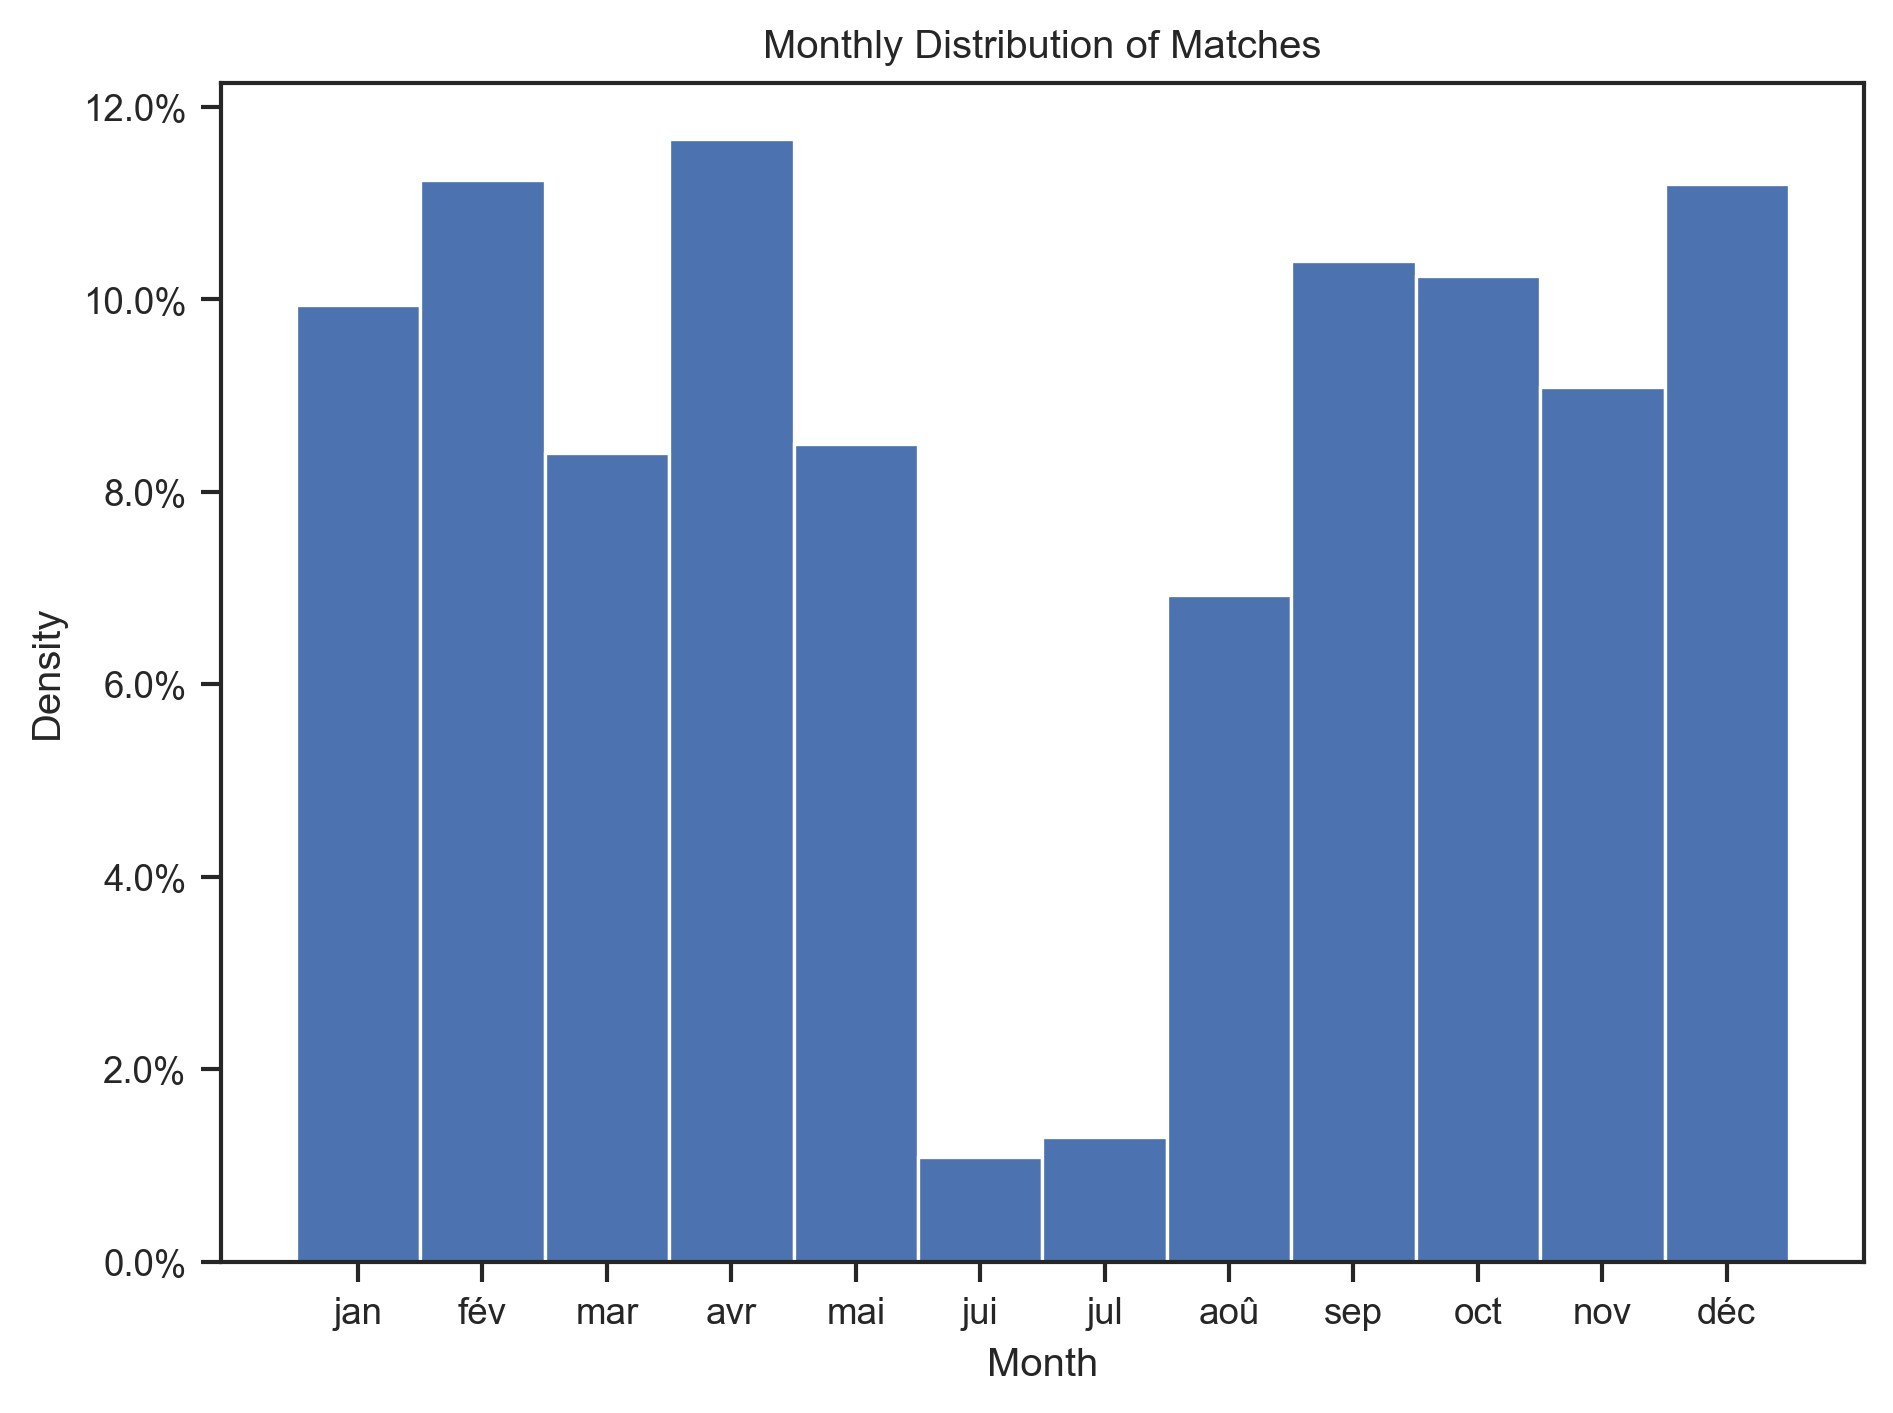

In [19]:
# | label: match_distribution

# Plot distribution of match
plt.figure()
sns.histplot(
    match_results["Date"].dt.month, bins=12, stat="density", discrete=True, alpha=1
)
plt.title("Monthly Distribution of Matches")
plt.xlabel("Month")
plt.ylabel("Density")
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
months = pd.date_range("2022-01-01", "2022-12-31", freq="ME").strftime("%b").tolist()
plt.xticks(range(1, 13), months)
plt.show()

### Effet du jeu à domicile ou à l'extérieur sur la performance des équipes

In [20]:
home_goal = match_results[match_results["isHome"]]["Goals"].mean()
away_goal = match_results[~match_results["isHome"]]["Goals"].mean()
diff_goal_perc = ((home_goal - away_goal) / home_goal) * 100

home_win = match_results[match_results["isHome"]]["Result"].value_counts(
    normalize=True
)["win"]
away_win = match_results[~match_results["isHome"]]["Result"].value_counts(
    normalize=True
)["win"]
diff_win_perc = (home_win - away_win) * 100
home_draw = match_results[match_results["isHome"]]["Result"].value_counts(
    normalize=True
)["draw"]

En moyenne, l’équipe qui joue à domicile marque {eval}`f'{home_goal:.2f}'` but contre {eval}`f'{away_goal:.2f}'` but pour l’équipe jouant à l’extérieur ({eval}`f'{diff_goal_perc:.0f}'`% moins de buts). Ainsi, les équipes jouant remportent {eval}`f'{home_win*100:.0f}'` % de leurs matchs contre {eval}`f'{away_win*100:.0f}'` % pour les équipes jouant à l'extérieur. Les matchs nuls représentent {eval}`f'{home_draw*100:.0f}'` % des matchs.

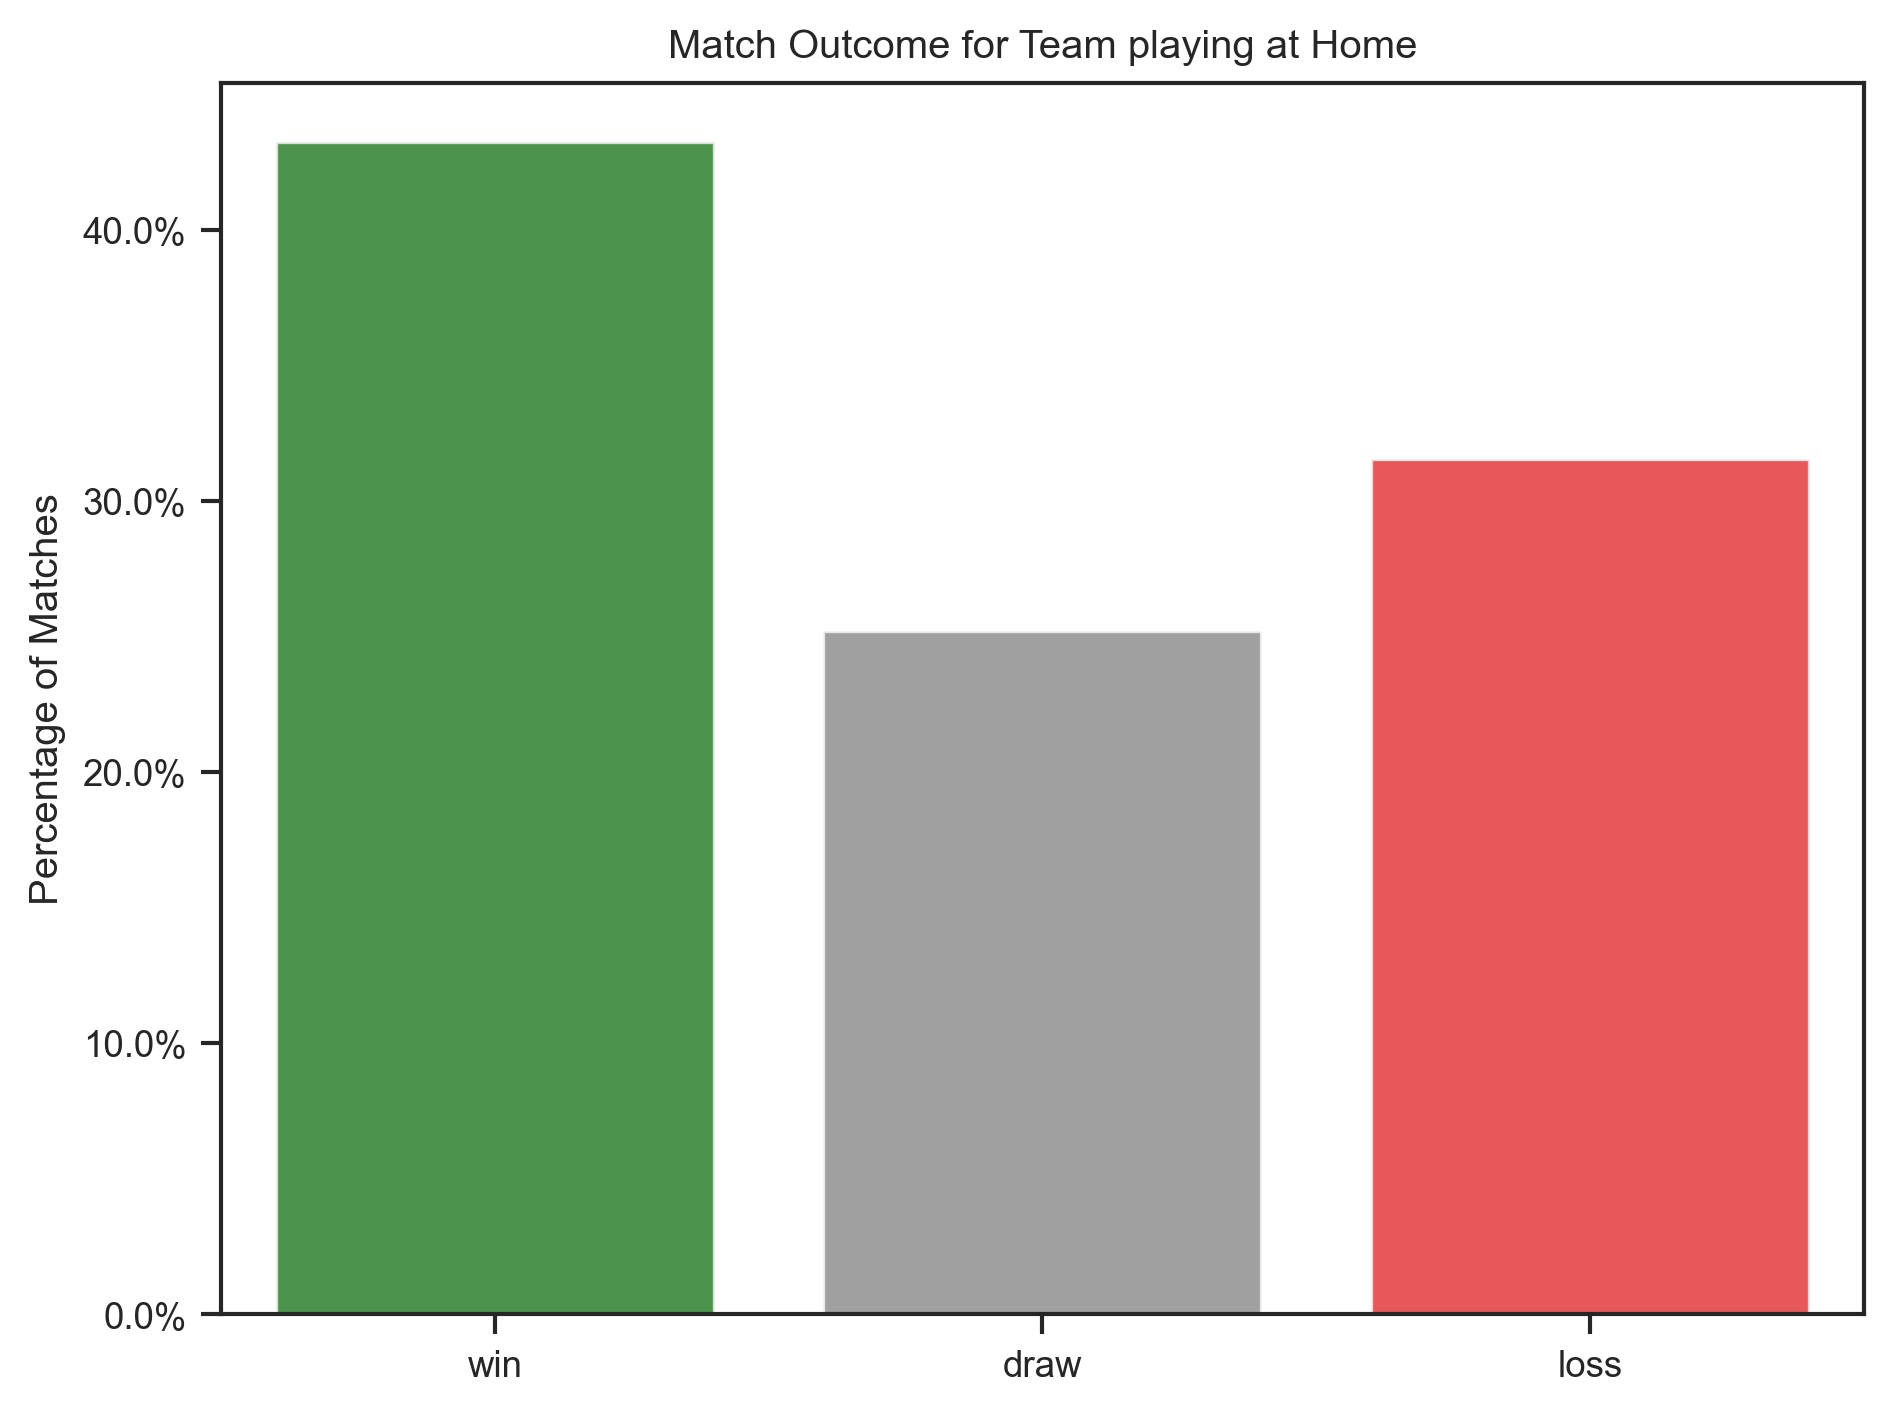

In [21]:
# | label: venue_effect
plt.figure()
sns.countplot(
    data=match_results[match_results["isHome"]],
    x="Result",
    hue="Result",
    order=["win", "draw", "loss"],
    stat="proportion",
    palette=["red", "green", "gray"],
    alpha=0.75,
)
plt.title("Match Outcome for Team playing at Home")
plt.xlabel("")
plt.ylabel("Percentage of Matches")
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))